<a href="https://colab.research.google.com/github/mitsouma/IOT_Anomalies_Detection_System_Based_on_Tensor_Decomposition/blob/main/Pipeline_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 81.8 MB/s eta 0:00:00


In [ ]:
import warnings
import numpy as np
import pandas as pd
from tensorly.decomposition import parafac
import tensorly as tl
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorly import unfold, fold
from tensorly.tenalg import khatri_rao
from numpy.linalg import lstsq
from tensorly.cp_tensor import cp_to_tensor
from sklearn.metrics import accuracy_score, log_loss
import time
from datetime import datetime
from sklearn.model_selection import train_test_split,KFold,cross_val_score
import torch
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt

"""
This pipeline is designed to detect anomalies in network traffic using a tensor-based deep learning approach.

Steps and Objectives:
---------------------
1. **Preprocessing & Tensor Construction**:
   - Multivariate network traffic data is aggregated over time windows.
   - A 4D tensor is built with dimensions: [Time_Window, Src IP, Dst IP,featues].

2. **Tensor Decomposition (CP)**:
   - The tensor is decomposed using CP (CANDECOMP/PARAFAC) to extract the underlying structure (normal behavior).
   - This reveals low-rank patterns, which capture typical traffic patterns.

3. **Reconstruction & Residual Calculation**:
   - We take the training tenssor and we compute its CP decomposition
   - Residuals are computed as the difference between the measure of the train tensor and the projection of this measure in the latent space.
4. **Anomaly Scoring**:
Since our goal aim to detect DDoS and DOS attack so:
   - Scores are aggregated per destination IP (`Dst IP`) and feature.
   - These scores reflect the degree of deviation from normal patterns.

5. **Deep Learning Classification**:
   - The aggregated anomaly scores are used as input to a neural network.
   - If labeled data is available, the model is trained in a supervised way to classify normal vs anomalous flows.
   - If labels are absent, an autoencoder is trained to learn normal behavior and detect deviations.

6. **Prediction**:
   - New traffic data is processed through the same pipeline.
   - The trained model predicts anomaly scores or binary classifications.

Main Goal:
----------
To detect abnormal network behavior in the IOT_data  by modeling traffic patterns as tensors, identifying deviations, and classifying them using deep learning models.
"""


In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
tl.set_backend('pytorch')

**Define the dataset**

In [ ]:
df1=pd.read_csv('/content/drive/MyDrive/BenignTraffic.pcap_Flow.csv')
df2=pd.read_csv('/content/drive/MyDrive/BenignTraffic1.pcap_Flow.csv')
df3=pd.read_csv('/content/drive/MyDrive/BenignTraffic2.pcap_Flow.csv')
df4=pd.read_csv('/content/drive/MyDrive/BenignTraffic3.pcap_Flow.csv')
df5=pd.read_csv('/content/drive/MyDrive/DDoS-HTTP_Flood-.pcap_Flow.csv')
df6=pd.read_csv('/content/drive/MyDrive/DoS-HTTP_Flood.pcap_Flow.csv')
df7=pd.read_csv('/content/drive/MyDrive/DoS-HTTP_Flood1.pcap_Flow.csv')

In [ ]:
df1['label']=0
df2['label']=0
df3['label']=0
df4['label']=0
df5['label']=1
df5['label']=1
df6['label']=1
df7['label']=1

In [ ]:
df1.replace([np.inf, -np.inf], np.nan, inplace=True)
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
df3.replace([np.inf, -np.inf], np.nan, inplace=True)
df4.replace([np.inf, -np.inf], np.nan, inplace=True)
df5.replace([np.inf, -np.inf], np.nan, inplace=True)
df6.replace([np.inf, -np.inf], np.nan, inplace=True)
df7.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
#Drop na
for df in [df1,df2,df3,df4,df5,df6,df7]:
   r=df.isna().sum()
   print("nan for :are :",r[r>0])

nan for :are : Flow Bytes/s      35
Flow Packets/s    35
dtype: int64
nan for :are : Flow Bytes/s      35
Flow Packets/s    35
dtype: int64
nan for :are : Flow Bytes/s      45
Flow Packets/s    45
dtype: int64
nan for :are : Flow Bytes/s      17
Flow Packets/s    17
dtype: int64
nan for :are : Flow Bytes/s      1123
Flow Packets/s    1123
dtype: int64
nan for :are : Flow Bytes/s      40786
Flow Packets/s    40786
dtype: int64
nan for :are : Flow Bytes/s      38735
Flow Packets/s    38735
dtype: int64


In [ ]:
#Shape of each dataset
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)
print(df6.shape)
print(df7.shape)

(183630, 85)
(84526, 85)
(91279, 85)
(38895, 85)
(505720, 85)
(932513, 85)
(710231, 85)


In [ ]:
#Drop duplicated rows
df1.drop_duplicates(inplace=True)
df2.drop_duplicates(inplace=True)
df3.drop_duplicates(inplace=True)
df4.drop_duplicates(inplace=True)
df5.drop_duplicates(inplace=True)
df6.drop_duplicates(inplace=True)
df7.drop_duplicates(inplace=True)

In [ ]:
df1.dropna(inplace=True)
df2.dropna(inplace=True)
df3.dropna(inplace=True)
df4.dropna(inplace=True)
df5.dropna(inplace=True)
df6.dropna(inplace=True)
df7.dropna(inplace=True)

In [ ]:
#Convert timestamp
df1['Timestamp']=pd.to_datetime(df1['Timestamp'])
df2['Timestamp']=pd.to_datetime(df2['Timestamp'])
df3['Timestamp']=pd.to_datetime(df3['Timestamp'])
df4['Timestamp']=pd.to_datetime(df4['Timestamp'])
df5['Timestamp']=pd.to_datetime(df5['Timestamp'])
df6['Timestamp']=pd.to_datetime(df6['Timestamp'])
df7['Timestamp']=pd.to_datetime(df7['Timestamp'])

In [ ]:
#Extract days
df1['Jour']=df1['Timestamp'].dt.date
df2['Jour']=df2['Timestamp'].dt.date
df3['Jour']=df3['Timestamp'].dt.date
df4['Jour']=df4['Timestamp'].dt.date
df5['Jour']=df5['Timestamp'].dt.date
df6['Jour']=df6['Timestamp'].dt.date
df7['Jour']=df7['Timestamp'].dt.date

In [ ]:
#Convert days
df1['Jour']=pd.to_datetime(df1['Jour'])
df2['Jour']=pd.to_datetime(df2['Jour'])
df3['Jour']=pd.to_datetime(df3['Jour'])
df4['Jour']=pd.to_datetime(df4['Jour'])
df5['Jour']=pd.to_datetime(df5['Jour'])
df6['Jour']=pd.to_datetime(df6['Jour'])
df7['Jour']=pd.to_datetime(df7['Jour'])

In [ ]:
df7['Jour'].unique()

<DatetimeArray>
['2022-09-08 00:00:00']
Length: 1, dtype: datetime64[ns]

In [ ]:
df5_day_1=df5[df5['Jour']=='2022-09-14']
df5_day_2=df5[df5['Jour']=='2022-11-07']
df6_day_1=df6[df6['Jour']=='2022-08-08']
df6_day_2=df6[df6['Jour']=='2022-09-08']

In [ ]:
#Extract time
df1['Heure']=df1['Timestamp'].dt.strftime('%H:%M:%S')
df2['Heure']=df2['Timestamp'].dt.strftime('%H:%M:%S')
df3['Heure']=df3['Timestamp'].dt.strftime('%H:%M:%S')
df4['Heure']=df4['Timestamp'].dt.strftime('%H:%M:%S')
df5_day_1['Heure']=df5_day_1['Timestamp'].dt.strftime('%H:%M:%S')
df5_day_2['Heure']=df5_day_2['Timestamp'].dt.strftime('%H:%M:%S')
df6_day_1['Heure']=df6_day_1['Timestamp'].dt.strftime('%H:%M:%S')
df6_day_2['Heure']=df6_day_2['Timestamp'].dt.strftime('%H:%M:%S')
df7['Heure']=df7['Timestamp'].dt.strftime('%H:%M:%S')

In [ ]:
#Create a relative time
df1['relative_time']=df1['Timestamp']-df1['Timestamp'].min()
df2['relative_time']=df2['Timestamp']-df2['Timestamp'].min()
df3['relative_time']=df3['Timestamp']-df3['Timestamp'].min()
df4['relative_time']=df4['Timestamp']-df4['Timestamp'].min()
df5_day_1['relative_time']=df5_day_1['Timestamp']-df5_day_1['Timestamp'].min()
df5_day_2['relative_time']=df5_day_2['Timestamp']-df5_day_2['Timestamp'].min()
df6_day_1['relative_time']=df6_day_1['Timestamp']-df6_day_1['Timestamp'].min()
df6_day_2['relative_time']=df6_day_2['Timestamp']-df6_day_2['Timestamp'].min()
df7['relative_time']=df7['Timestamp']-df7['Timestamp'].min()

In [ ]:
#Normal filter
hours = df1['relative_time'].dt.total_seconds() / 3600
mask_3h = hours <= 1
df_3h = df1[mask_3h]
#Train filter
hours_t = df4['relative_time'].dt.total_seconds() / 3600
mask_3h_t = hours_t <= 1
df_3h_t = df4[mask_3h_t]
#Test filter
hours_3h_test = df3['relative_time'].dt.total_seconds() / 3600
mask_3h_test = hours_3h_test <= 1
df_3h_test = df3[mask_3h_test]
#Anomalous filter
hours_3h_test_a = df5_day_2['relative_time'].dt.total_seconds() / 3600
mask_3h_test_a = hours_3h_test_a <= 1
df_3h_test_a = df5_day_2[mask_3h_test_a]
df7_2h=df7[df7['relative_time']<pd.Timedelta(hours=1)]

# DATA CONSTRUCTION

In [ ]:
#Consider for as normal_data "Benign 1 ":
df_normal=df_3h
#Training data:
df_train=pd.concat([df_3h_t,df5_day_1,df7_2h],axis=0)
df_test=pd.concat([df_3h_test,df_3h_test_a,df6_day_2],axis=0)

In [ ]:
df_normal['Dst IP'].nunique()

323

# NORMALISE SOME COLUMNS

In [ ]:
df_train['Flow Packets/s']=(df_train['Flow Packets/s']-min(df_train['Flow Packets/s']))/(max(df_train['Flow Packets/s'])-min(df_train['Flow Packets/s']))
df_train['Flow Duration']=(df_train['Flow Duration']-min(df_train['Flow Duration']))/(max(df_train['Flow Duration'])-min(df_train['Flow Duration']))
df_train['Flow Bytes/s']=(df_train['Flow Bytes/s']-min(df_train['Flow Bytes/s']))/(max(df_train['Flow Bytes/s'])-min(df_train['Flow Bytes/s']))

In [ ]:
df_normal['Flow Bytes/s']=(df_normal['Flow Bytes/s']-min(df_normal['Flow Bytes/s']))/(max(df_normal['Flow Bytes/s'])-min(df_normal['Flow Bytes/s']))
df_normal['Flow Duration']=(df_normal['Flow Duration']-min(df_normal['Flow Duration']))/(max(df_normal['Flow Duration'])-min(df_normal['Flow Duration']))
df_normal['Flow Packets/s']=(df_normal['Flow Packets/s']-min(df_normal['Flow Packets/s']))/(max(df_normal['Flow Packets/s'])-min(df_normal['Flow Packets/s']))

In [ ]:
df_test['Flow Packets/s']=(df_test['Flow Packets/s']-min(df_test['Flow Packets/s']))/max(df_test['Flow Packets/s'])
df_test['Flow Duration']=(df_test['Flow Duration']-min(df_test['Flow Duration']))/max(df_test['Flow Duration'])
df_test['Flow Bytes/s']=(df_test['Flow Bytes/s']-min(df_test['Flow Bytes/s']))/max(df_test['Flow Bytes/s'])

# TENSOR CONSTRUCTION

In [ ]:
def create_graph_tensor(df, window_size=300):
    # Détection du device (GPU si disponible)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Extraction des IPs uniques
    src_ips = df['Src IP'].unique()
    dst_ips = df['Dst IP'].unique()

    src_ip_to_idx = {ip: idx for idx, ip in enumerate(src_ips)}
    dst_ip_to_idx = {ip: idx for idx, ip in enumerate(dst_ips)}

    # Création des fenêtres temporelles
    df['time_window'] = df['relative_time'].astype(np.int64) // (10**9 * window_size)
    time_windows = sorted(df['time_window'].unique())

    # Création du tenseur sur CPU d'abord
    tensor_cpu = torch.zeros((len(time_windows), 751, 849, 4), dtype=torch.float32)

    for _, group in df.groupby(['time_window', 'Src IP', 'Dst IP']):
        t_idx = np.where(time_windows == group['time_window'].iloc[0])[0][0]
        src_idx = src_ip_to_idx[group['Src IP'].iloc[0]]
        dst_idx = dst_ip_to_idx[group['Dst IP'].iloc[0]]

        tensor_cpu[t_idx, src_idx, dst_idx, 0] = len(group)
        tensor_cpu[t_idx, src_idx, dst_idx, 1] = group['Flow Bytes/s'].sum()
        tensor_cpu[t_idx, src_idx, dst_idx, 2] = group['Flow Duration'].mean()
        tensor_cpu[t_idx, src_idx, dst_idx, 3] = group['Flow Packets/s'].sum()

    # Transfert du tenseur sur GPU si disponible
    tensor = tensor_cpu.to(device)

    print("Tensor well created : shape =", tensor.shape)
    print("Number of non-zeros =", (tensor != 0).sum().item())
    print("Number of elements =", tensor.numel())
    return tensor, src_ip_to_idx, dst_ip_to_idx, time_windows


# Tensor Normalisation

In [ ]:
def normalize_tensor_feature(tensor, feature_index):
    # Extract the feature slice
    feature_slice = tensor[:, :, :, feature_index]

    # Calculate min and max
    min_val = torch.min(feature_slice)
    max_val = torch.max(feature_slice)

    # Apply min-max normalization
    if max_val - min_val > 0:
        normalized_slice = (feature_slice - min_val) / (max_val - min_val)
    else:
        # All values are the same
        normalized_slice = feature_slice - min_val  # results in all zeros

    # Replace the original feature with the normalized one
    tensor[:, :, :, feature_index] = normalized_slice

    return tensor


In [ ]:

# Unpack the tuple into separate variables
tensor_normal, src_ip_to_idx, dst_ip_to_idx, time_windows = create_graph_tensor(df_normal, window_size=300)

# Now normalize the tensor object
tensor_normal = normalize_tensor_feature(tensor_normal, 0)
tensor_normal = normalize_tensor_feature(tensor_normal, 1)
tensor_normal = normalize_tensor_feature(tensor_normal, 2)
tensor_normal = normalize_tensor_feature(tensor_normal, 3)

# If you need to update the original 'tensor_data' variable to contain the modified tensor
# and the other elements, you can create a new tuple:

# Repeat the unpacking and normalization for tensor_data_normal and tensor_data_test as well
tensor_train, src_ip_to_idx_train, dst_ip_to_idx_train, time_windows_train = create_graph_tensor(df_train, window_size=300)
tensor_train = normalize_tensor_feature(tensor_train, 0)
tensor_train = normalize_tensor_feature(tensor_train, 1)
tensor_train = normalize_tensor_feature(tensor_train, 2)
tensor_train = normalize_tensor_feature(tensor_train, 3)

tensor_test, src_ip_to_idx_test, dst_ip_to_idx_test, time_windows_test = create_graph_tensor(df_test, window_size=300)
tensor_test = normalize_tensor_feature(tensor_test, 0)
tensor_test = normalize_tensor_feature(tensor_test, 1)
tensor_test = normalize_tensor_feature(tensor_test, 2)
tensor_test = normalize_tensor_feature(tensor_test, 3)

Using device: cuda
Tensor well created : shape = torch.Size([13, 751, 849, 4])
Number of non-zeros = 10251
Number of elements = 33155148
Using device: cuda
Tensor well created : shape = torch.Size([12, 751, 849, 4])
Number of non-zeros = 26300
Number of elements = 30604752
Using device: cuda
Tensor well created : shape = torch.Size([13, 751, 849, 4])
Number of non-zeros = 20547
Number of elements = 33155148


✅ Rank : 1, Error : 0.8736
✅ Rank : 2, Error : 0.8109
✅ Rank : 3, Error : 0.7673
✅ Rank : 4, Error : 0.7230
✅ Rank : 5, Error : 0.6910
✅ Rank : 6, Error : 0.6671
✅ Rank : 7, Error : 0.6443
✅ Rank : 8, Error : 0.6265
✅ Rank : 9, Error : 0.6116
✅ Rank : 10, Error : 0.5933
✅ Rank : 11, Error : 0.5830
✅ Rank : 12, Error : 0.5636
✅ Rank : 13, Error : 0.5502
✅ Rank : 14, Error : 0.5409
✅ Rank : 15, Error : 0.5296
✅ Rank : 16, Error : 0.5196
✅ Rank : 17, Error : 0.5072
✅ Rank : 18, Error : 0.4959
✅ Rank : 19, Error : 0.4864
✅ Rank : 20, Error : 0.4745
✅ Rank : 21, Error : 0.4630
✅ Rank : 22, Error : 0.4521
✅ Rank : 23, Error : 0.4413
✅ Rank : 24, Error : 0.4305
✅ Rank : 25, Error : 0.4221
✅ Rank : 26, Error : 0.4080
✅ Rank : 27, Error : 0.3975
✅ Rank : 28, Error : 0.3840
✅ Rank : 29, Error : 0.3746
✅ Rank : 30, Error : 0.3626
✅ Rank : 31, Error : 0.3447
✅ Rank : 32, Error : 0.3320
✅ Rank : 33, Error : 0.3186
✅ Rank : 34, Error : 0.3052
✅ Rank : 35, Error : 0.2997
✅ Rank : 36, Error : 0.2788
✅

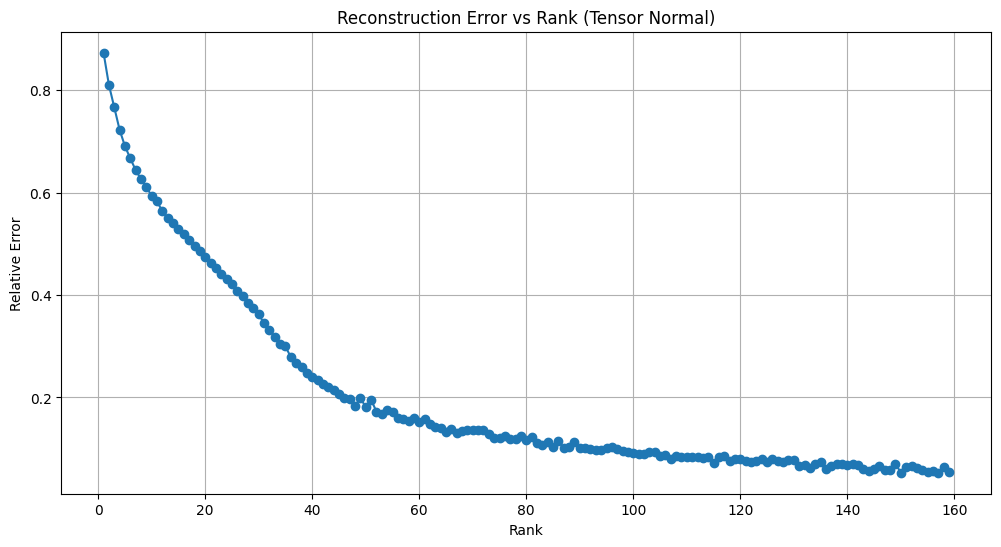

In [ ]:
# Initialisation des listes
factors_normal_list = []
error_normal_list = []
ranks_tested=[]

# Décompositions CP avec pas de 1
for rank in range(1, 160, 1):
    # Libération mémoire GPU avant chaque décomposition
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Décomposition CP
    factors_normal = parafac(tensor_normal, rank=rank, n_iter_max=100, init='random', verbose=False)
    reconstruction = cp_to_tensor(factors_normal)

    # Calcul de l'erreur de reconstruction
    error = tl.norm(tensor_normal - reconstruction) / tl.norm(tensor_normal)

    # Stockage des résultats
    factors_normal_list.append(factors_normal)
    error_normal_list.append(error.item())
    ranks_tested.append(rank)

    print(f"✅ Rank : {rank}, Error : {error.item():.4f}")

# Libération mémoire GPU après toutes les décompositions
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Tracé de l'erreur de reconstruction
plt.figure(figsize=(12, 6))
plt.plot(ranks_tested, error_normal_list, marker='o')
plt.xlabel('Rank')
plt.ylabel('Relative Error')
plt.title('Reconstruction Error vs Rank (Tensor Normal)')
plt.grid(True)
plt.show()


**Normal Projection**

In [ ]:
def normal_space_projection(tensor_input, tensor_ref):
    # Extraire les facteurs de la décomposition de référence
    lambdas_ref, (A_ref, B_ref, C_ref, D_ref) = tensor_ref
    rank = lambdas_ref.shape[0]

    device = tensor_input.device
    tensor_input = tensor_input.to(torch.float32).to(device)
    B_ref = B_ref.to(torch.float32).to(device)
    C_ref = C_ref.to(torch.float32).to(device)
    D_ref = D_ref.to(torch.float32).to(device)
    lambdas_ref = lambdas_ref.to(torch.float32).to(device)

    # Étape 1 : décomposition CP de tensor_input au même rang que tensor_ref
    cp_input = parafac(tensor_input, rank=rank, n_iter_max=100, init='random', verbose=False)
    low_rank_tensor_input = cp_to_tensor(cp_input)  # reconstruction low-rank du tenseur input

    # Étape 2 : projection de low_rank_tensor_input dans l’espace de (B, C, D)
    # pondération des facteurs de référence
    B_w = B_ref * lambdas_ref.view(1, -1)
    C_w = C_ref * lambdas_ref.view(1, -1)
    D_w = D_ref * lambdas_ref.view(1, -1)

    # Khatri-Rao product pondéré
    kr_product = tl.tenalg.khatri_rao([D_w, tl.tenalg.khatri_rao([C_w, B_w])])
    kr_pinv = torch.linalg.pinv(kr_product.T)  # pseudo-inverse du Khatri-Rao

    num_time_slices = low_rank_tensor_input.shape[0]
    A_proj = torch.zeros((num_time_slices, rank), dtype=torch.float32, device=device)

    for t in range(num_time_slices):
        slice_t = low_rank_tensor_input[t].reshape(1, -1)  # shape: (1, features)
        A_proj[t] = slice_t @ kr_pinv  # projection

    # Étape 3 : reconstruction du tenseur projeté
    low_rank_projected = cp_to_tensor((torch.ones(rank, device=device), [A_proj, B_ref, C_ref, D_ref]))

    # Étape 4 : calcul du résidu
    residual = low_rank_tensor_input - low_rank_projected

    print("✅ Décomposition, projection et résidu calculés.")
    print("Norme du résidu :", tl.norm(residual).item())

    return residual


✅ Décomposition, projection et résidu calculés.
Norme du résidu : 18.635286331176758
✅ Residual calculé.
✅ Rank : 1
✅ Error : 0.43912604451179504
✅ Décomposition, projection et résidu calculés.
Norme du résidu : 21.795228958129883
✅ Residual calculé.
✅ Rank : 2
✅ Error : 0.5135876536369324
✅ Décomposition, projection et résidu calculés.
Norme du résidu : 23.779132843017578
✅ Residual calculé.
✅ Rank : 3
✅ Error : 0.5603368282318115
✅ Décomposition, projection et résidu calculés.
Norme du résidu : 25.02140998840332
✅ Residual calculé.
✅ Rank : 4
✅ Error : 0.5896100997924805
✅ Décomposition, projection et résidu calculés.
Norme du résidu : 26.1839542388916
✅ Residual calculé.
✅ Rank : 5
✅ Error : 0.6170045733451843
✅ Décomposition, projection et résidu calculés.
Norme du résidu : 26.980052947998047
✅ Residual calculé.
✅ Rank : 6
✅ Error : 0.6357640027999878
✅ Décomposition, projection et résidu calculés.
Norme du résidu : 27.566564559936523
✅ Residual calculé.
✅ Rank : 7
✅ Error : 0.6495

Text(0, 0.5, 'Relative Error')

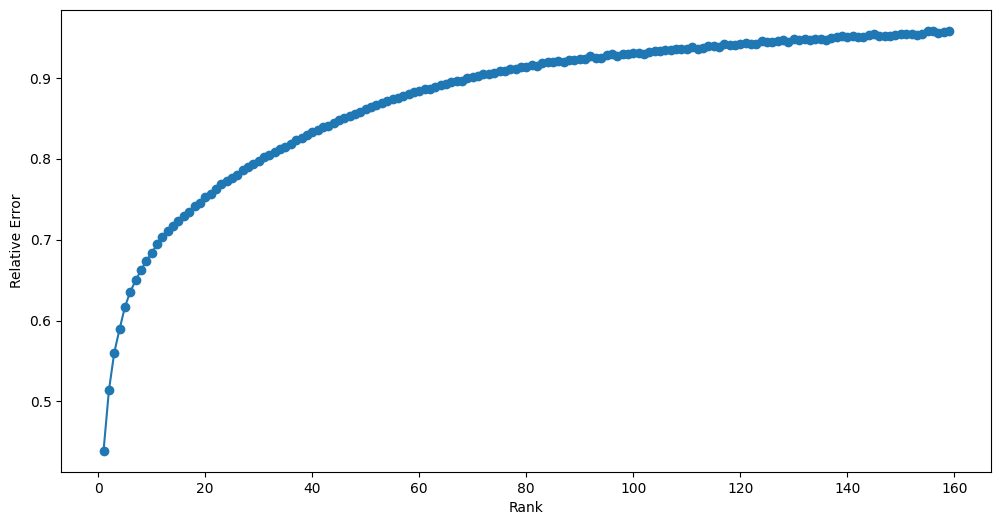

In [ ]:
residuals_train_list=[]
error_train_list=[]
rank_list=[]
for tensor in factors_normal_list:
    residuals_train = normal_space_projection(tensor_train, tensor)
    residuals_train_list.append(residuals_train)
    error_train=tl.norm(residuals_train)/tl.norm(tensor_train)
    error_train_list.append(error_train.item())
    print("✅ Residual calculé.")
    rank_list.append(tensor[0].shape[0])
    print("✅ Rank :",tensor[0].shape[0])
    print("✅ Error :",error_train.item())

fig=plt.figure(figsize=(12,6))
plt.plot(rank_list,error_train_list,marker='o')
plt.xlabel('Rank')
plt.ylabel('Relative Error')

In [ ]:
tl.norm(residuals_train_list[158])

tensor(40.6212, device='cuda:0')

# AGGREGATION_SCORING

In [ ]:
def aggregation_scoring_Source(residuals, mappings, df_with_labels, window_size=300):
    print("⏳ Étape 4 : Aggrégation des scores avec labels...")

    # 1. Convertir relative_time -> time_window (entier)
    df_with_labels = df_with_labels.copy()
    df_with_labels['time_window'] = df_with_labels['relative_time'].astype(np.int64) // (10**9 * window_size)

    # 2. Créer le mapping des labels (Dst IP, time_window) -> label
    label_map = {}
    for _, row in df_with_labels.iterrows():
        key = (row['Dst IP'], int(row['time_window']))
        label = int(row['label']) if pd.notnull(row['label']) else 0
        label_map[key] = max(label_map.get(key, 0), label)

    # 3. Préparer les dimensions
    # Move the tensor to CPU before converting to NumPy
    residuals_np = tl.to_numpy(residuals.cpu())
    idx_to_dst_ip = {idx: ip for ip, idx in mappings['Dst_IP'].items()}
    idx_to_feature = {idx: feat for idx, feat in mappings['features_names'].items()}
    time_dim, _, dst_dim, feat_dim = residuals_np.shape

    # 4. Construire la liste des time_windows à partir de l’index
    time_windows = list(range(time_dim))

    # 5. Aggrégation + étiquetage
    aggregation = {}
    for t in range(time_dim):
        time_window = time_windows[t]
        for d in range(dst_dim):
            # Check if the index 'd' exists in idx_to_dst_ip
            if d in idx_to_dst_ip:
                dst_ip = idx_to_dst_ip[d]
                key = (dst_ip, time_window)

                if key not in aggregation:
                    aggregation[key] = {
                        'Dst IP': dst_ip,
                        'time_windows': time_window,
                        'count': 0,
                        'bytes': 0,
                        'packets': 0,
                        'duration': 0,
                        'label': label_map.get(key, 0)  # label ajouté ici
                    }

                for f in range(feat_dim):
                    feature_name = idx_to_feature[f].lower()
                    score = np.sum(np.abs(residuals_np[t, :, d, f]))

                    if 'count' in feature_name:
                        aggregation[key]['count'] += score
                    elif 'bytes' in feature_name:
                        aggregation[key]['bytes'] += score
                    elif 'packets' in feature_name:
                        aggregation[key]['packets'] += score
                    elif 'duration' in feature_name:
                        aggregation[key]['duration'] += score
            else:
                continue

    df_scores = pd.DataFrame(list(aggregation.values()))

    #log_step("Étape 4", start)
    print("✅ Aggrégation des scores + labels terminée.")

    return df_scores

In [ ]:
mappings={'Dst_IP':dst_ip_to_idx_train,'features_names':dict(enumerate(['count','bytes','packets','duration']))}

In [ ]:
def remove_outliers_iqr(df, features):
    cleaned_df = df.copy()
    for col in features:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Filtrer les lignes en fonction de la colonne actuelle
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)]
    return cleaned_df


In [ ]:
df_score_list=[]
rank=1
for df in residuals_train_list:
    df_scores_train=aggregation_scoring_Source(df,mappings, df_train, window_size=300)
    df_score_list.append(df_scores_train)
    print('rank , ', rank)
    print("✅ Score calculé.")
    rank+=1

⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
rank ,  1
✅ Score calculé.
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
rank ,  2
✅ Score calculé.
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
rank ,  3
✅ Score calculé.
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
rank ,  4
✅ Score calculé.
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
rank ,  5
✅ Score calculé.
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
rank ,  6
✅ Score calculé.
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
rank ,  7
✅ Score calculé.
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
rank ,  8
✅ Score calculé.
⏳ Étape 4 : Aggrégation des scor

KeyboardInterrupt: 

In [ ]:
df_cleaned_list=[]
features=['count','bytes','packets','duration']
for df in df_score_list:
    removed=remove_outliers_iqr(df,features)
    print("✅ Outliers supprimés.")
    df_cleaned=pd.concat([removed,df[df['label']==1]],axis=0)
    df_cleaned_list.append(df_cleaned)


✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers supprimés.
✅ Outliers

In [ ]:
def build_and_train_binary_classifier(X_train, y_train, X_test, y_test, learning_rate=0.0001, batch_size=10, epochs=30):
    input_dim = X_train.shape[1]

    # Définition du modèle
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='sigmoid'),
        layers.Dense(80, activation='sigmoid'),
        layers.Dense(80, activation='sigmoid'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='sigmoid'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='sigmoid'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')

    ])

    # Compilation
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )


    # Entraînement
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )

    return model, history


In [ ]:
model_list=[]
history_list=[]
for df in df_cleaned_list:
      X1=df.drop(columns=['label','Dst IP','time_windows'])
      Y1=df['label']
      X1_train,X1_test,Y1_train,Y1_test = train_test_split(X1,Y1,test_size=0.3,stratify=Y1)
      model,history=build_and_train_binary_classifier(X1_train, Y1_train, X1_test, Y1_test)
      model_list.append(model)
      history_list.append(history)
      print("✅ Model et history calculés.")
      # Prédire les probabilités (entre 0 et 1)
      y_pred_prob = model.predict(X1_test)
      # Convertir les probabilités en classes binaires (0 ou 1)
      y_pred = (y_pred_prob > 0.5).astype(int)
      # Calcul de la matrice de confusion
      cm = confusion_matrix(Y1_test, y_pred)
      # Affichage
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
      disp.plot(cmap='Blues')


Epoch 1/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.4681 - auc: 0.4990 - loss: 0.7531 - val_accuracy: 0.6747 - val_auc: 0.5000 - val_loss: 0.6316
Epoch 2/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6407 - auc: 0.4967 - loss: 0.6574 - val_accuracy: 0.6747 - val_auc: 0.5049 - val_loss: 0.6310
Epoch 3/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6666 - auc: 0.4959 - loss: 0.6454 - val_accuracy: 0.6747 - val_auc: 0.5000 - val_loss: 0.6309
Epoch 4/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6692 - auc: 0.4813 - loss: 0.6468 - val_accuracy: 0.6747 - val_auc: 0.5000 - val_loss: 0.6308
Epoch 5/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6679 - auc: 0.4867 - loss: 0.6438 - val_accuracy: 0.6747 - val_auc: 0.5000 - val_loss: 0.6308
Epoch 6/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6807 - auc: 0.5075 - loss: 0.6325 - val_accuracy: 0.6747 - val_auc: 0.5025 - val_loss: 0.6308
Epoch 7/30
439/439 ━━━━━━━━━━━━━━━━━━━

In [ ]:
residuals_test_list=[]
for tensor in factors_normal_list:
    residuals_test = normal_space_projection(tensor_test, tensor)
    residuals_test_list.append(residuals_test)
    print("✅ Residual calculé.")
    print("✅ Rank :",tensor[0].shape[0])

✅ Décomposition, projection et résidu calculés.
Norme du résidu : 25.623950958251953
✅ Décomposition, projection et résidu calculés.
Norme du résidu : 29.704952239990234
✅ Décomposition, projection et résidu calculés.
Norme du résidu : 32.67353820800781
✅ Décomposition, projection et résidu calculés.
Norme du résidu : 34.779632568359375
✅ Décomposition, projection et résidu calculés.
Norme du résidu : 36.55741500854492
✅ Décomposition, projection et résidu calculés.
Norme du résidu : 37.84404373168945
✅ Décomposition, projection et résidu calculés.
Norme du résidu : 38.78063201904297
✅ Décomposition, projection et résidu calculés.
Norme du résidu : 39.6094856262207
✅ Décomposition, projection et résidu calculés.
Norme du résidu : 40.29451370239258
✅ Décomposition, projection et résidu calculés.
Norme du résidu : 40.92143630981445
✅ Décomposition, projection et résidu calculés.
Norme du résidu : 41.44010543823242
✅ Décomposition, projection et résidu calculés.
Norme du résidu : 41.92028

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.13 GiB. GPU 0 has a total capacity of 39.56 GiB of which 1002.88 MiB is free. Process 28655 has 38.57 GiB memory in use. Of the allocated memory 28.90 GiB is allocated by PyTorch, and 8.87 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
mappings_test={'Dst_IP':dst_ip_to_idx_test,'features_names':dict(enumerate(['count','bytes','packets','duration']))}

In [ ]:
df_score_test_list=[]
for residual in residuals_train_list:
    df_scores_train=aggregation_scoring_Source(residual,mappings, df_train, window_size=300)
    df_score_list.append(df_scores_train)
    print("✅ Rank :",residual[0].shape[0])
    print("shape=",df_scores_train.shape)
    df_scores_train['label'].value_counts().plot(kind='bar', title='Label Distribution')
    plt.show()
    print("✅ Score calculé.")

In [ ]:
df_cleaned_list=[]
features=['time_windows','label','Dst IP']
for df in df_score_test_list:
    removed=remove_outliers_iqr(df,features)
    print("✅ Outliers supprimés.")
    df_cleaned=pd.concat([removed,df[df['label']==1]],axis=0)
    df_cleaned_list.append(df_cleaned)

In [ ]:
for df in df_cleaned_list:
  for model in model_list:
      X=df.drop(columns=['label','Dst IP','time_windows'])
      Y=df['label']
      y_pred_prob = model.predict(X)
      # Convertir les probabilités en classes binaires (0 ou 1)
      y_pred = (y_pred_prob > 0.5).astype(int)
      # Calcul de la matrice de confusion
      cm = confusion_matrix(Y, y_pred)
      # Affichage
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
      disp.plot(cmap='Blues')
